# IDL Map Software for Analyzing Solar Images
### Shelbe Timothy (Oct 29,2019) 


## Introduction
 An IDL map is a structure that contains two-dimensional image data with accompanying pixel coordinate and spatial scale information. The parameters are defined as properties of the map and are unique for each image source. This header or meta data allows image to be manipulated or transformed in a manner that is independent of the image source.

This notebook describes how to create and use maps to process solar images using the SolarSoft library - a set of integrated software libraries, databases, and system utilities which provide a "common" programming and data analysis environment for Solar Physics. . We will use sample images obtained from instruments onboard SOHO, IRIS, and SDO missions. Some typical processing tasks include: roll-correction, stretching, translation, solar rotation-compensation, and image coalignment. (http://www.lmsal.com/solarsoft) 

### 1.1 Creating a Map
The low-level function for creating a map is __make_map__. In this example, a 256x256 array is created with findgen and converted to a map variable: 

In [0]:
image=findgen(256,256)
mmap=make_map(image)
help, /st, mmap

** Structure <91ce2df8>, 12 tags, length=262272, data length=262268, refs=1:
 DATA FLOAT Array[256, 256]
 XC DOUBLE 0.0000000
 YC DOUBLE 0.0000000
 DX DOUBLE 1.0000000
 DY DOUBLE 1.0000000
 TIME STRING '23-May-2021 19:14:08.00'
 ID STRING ''
 DUR FLOAT 0.00000
 XUNITS STRING 'arcsec'
 YUNITS STRING 'arcsec'
 ROLL_ANGLE DOUBLE 0.0000000
 ROLL_CENTER DOUBLE Array[2]

The resulting map is an anonymous structure with the following tag definitions:

- DATA: the 2-d data values.
- XC, YC: the cartesian coordinates of center of the image. Since coordinate information was not specified, the origin is used as the default value.
- DX, DY: the spacing between between pixels in the cartesian X and Y directions, respectively. Since spatial scale was not specified, the spacings default to unity.
- TIME: a reference time for the image. It could be the start or mean time of the image. The default time is the current Universal Time (UT) when the map is created. 

The above tag definitions are defined also as keywords in __make_map__. For example, a map with a pixel spacing of 2 units in the x-direction and 3 units in the y-direction is created by: 

In [1]:
image=findgen(256,256) 
mmap=make_map(image,dx=2,dy=3)
help,/st,mmap

** Structure , 12 tags, length=262272, data length=262268, refs=1:
 DATA FLOAT Array[256, 256]
 XC DOUBLE 0.0000000
 YC DOUBLE 0.0000000
 DX DOUBLE 2.0000000
 DY DOUBLE 3.0000000
 TIME STRING '23-May-2021 19:14:09.00'
 ID STRING ''
 DUR FLOAT 0.00000
 XUNITS STRING 'arcsec'
 YUNITS STRING 'arcsec'
 ROLL_ANGLE DOUBLE 0.0000000
 ROLL_CENTER DOUBLE Array[2]

Note that the basic map structure definition is kept intentionally simple, with data and coordinate parameters being the main defining properties. The units of the coordinate system are also arbitrary. Additional properties are added two ways:

1. At the definition stage. For example, to include a property _UNITS_ that specifies coordinate units: 

In [2]:
nmap=make_map(image,units='arcsecs')
help,nmap,/st

** Structure <62a3e388>, 13 tags, length=262288, data length=262284, refs=1:
 DATA FLOAT Array[256, 256]
 XC DOUBLE 0.0000000
 YC DOUBLE 0.0000000
 DX DOUBLE 1.0000000
 DY DOUBLE 1.0000000
 TIME STRING '23-May-2021 19:14:09.00'
 ID STRING ''
 DUR FLOAT 0.00000
 XUNITS STRING 'arcsec'
 YUNITS STRING 'arcsec'
 ROLL_ANGLE DOUBLE 0.0000000
 ROLL_CENTER DOUBLE Array[2]
 UNITS STRING 'arcsecs'

2. After the definition stage. Following the same example, but using the function __add_prop__ produces the same result. Multiple properties are added as multiple keywords, with the restriction that each property name is unique.  

In [3]:
add_prop,mmap,units='arcsecs'

### 1.2 Plotting a Map
Maps are plotted using the procedure __plot_map__. Thus, using the 2-d image created earlier, 

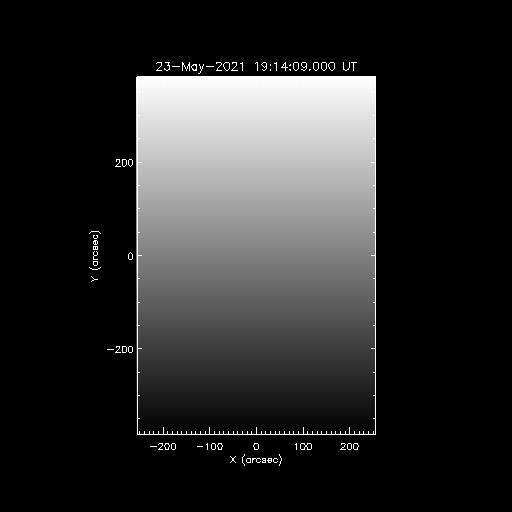

In [4]:
plot_map, mmap

 The procedure plot_map inherits all the major IDL plot keywords such as xstyle, ystyle, font, charsize, charthick, etc. It supports the following additional keywords:

- _range_: 2-element vector of data min and max to display
- _xrange_: 2-element vector of xmin and xmax to display
- _yrange_: 2-element vector of ymin and ymax to display
- _/log_: display using log10 scaling
- _xsize_, _ysize_: device pixel size for the plot window [def=512x512]
- _/noaxes_: inhibit plotting axes
- _/nolabels_: inhibit printing axis labels
- _/notitle_: inhibit printing title
- _/cont_: plot image as a contour
- _levels_: an array of contour levels 

The use of more advanced keywords will be demonstrated later in this tutorial. 

### 1.3 Plotting Maps on Different Color Scales
The key to plotting with separate color tables is to divide evenly the total number of available device colors. The latter is given by the system variable !d.table_size. In the above example, the total available colors is 200. Hence, the color table is split into two equal halves of nc=100 colors each. The routine loadct loads a red color table (#3) into the first 0 to nc-1 color range, and blue color table (#1) into the second nc to 2*nc-1 range. The keyword _/new_ forces the creation of a new plot window. The resulting plots appear as: 

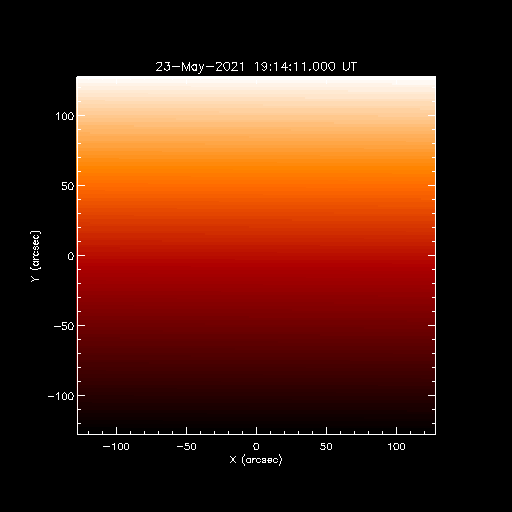

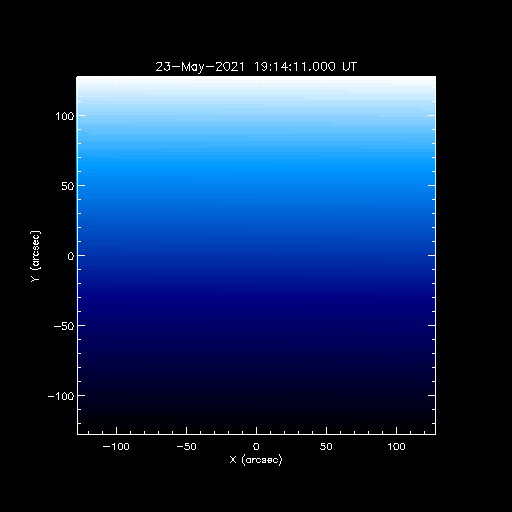

In [5]:
image=findgen(256,256) 
mmap=make_map(image)                ;-- make a simple map
nc=100                             ;-- # of colors per image
loadct,3,ncolors=nc                ;-- load red table from  0:nc-1
plot_map,mmap,ncolors=nc            ;-- plot map using red table
loadct,1,bottom=nc,ncolors=nc      ;-- load blue table from nc:2*nc-1
plot_map,mmap,bottom=nc,ncolors=nc, /new  ;-- plot using blue table

## 2. Operations with Maps
 The following examples demonstrate various image processing that can be applied to maps.
###  2.1 Rotating a Map
Maps are rotated using the function __rot_map__ . An interesting example is provided by rotating (i.e, rolling) a _SOHO EIT_ full Sun image. The routines for creating a solar image map and will be described in section 3 . Below is a 512x512 EIT map, *eit_map* with the following properties: 

In [6]:
files=eit_files('14-mar-00','15-mar-00',wave=304)
help, files[0]
read_eit,files[0],index,data
index2map,index,data,eit_map
help, eit_map

STRING = '/archive/soho/eit/eit_lz/2000/03/efz20000314.000010'

** Structure <62a9b118>, 16 tags, length=524448, data length=524437, refs=1:
 DATA INT Array[512, 512]
 XC DOUBLE 15.668818
 YC DOUBLE -11.909447
 DX DOUBLE 5.2579999
 DY DOUBLE 5.2579999
 TIME STRING '14-Mar-2000 00:00:04.386'
 ID STRING 'SOHO EIT Rocket Science 195'
 DUR FLOAT 4.64100
 XUNITS STRING 'arcsec'
 YUNITS STRING 'arcsec'
 ROLL_ANGLE DOUBLE 0.070000000
 ROLL_CENTER DOUBLE Array[2]
 SOHO BYTE 1
 L0 DOUBLE 0.0000000
 B0 DOUBLE -7.1798987
 RSUN DOUBLE 964.52584

This map contains an EIT 304 Angstrom image that has been double-binned from its original 1024x1024 size. Note the additional properties *ID* specifying the image wavelength, *DUR* specifying the image duration, and *SOHO* specifying image source. To rotate this map through, say, 60 degrees clockwise about its center, and display the results. (Notice our color table from above is preserved): 

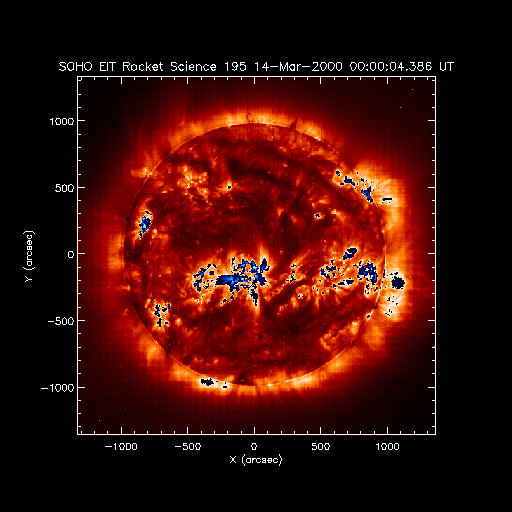

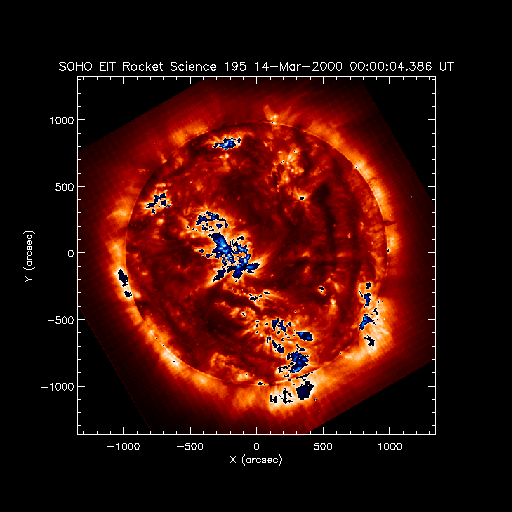

In [7]:
rmap=rot_map(eit_map,60.)
plot_map,eit_map, /log
plot_map,rmap,/log,/new

The rotation is performed by rotating the coordinates of each image pixel, computing a new grid of rotated coordinates, and interpolating the new grid back to the original image. Generally, the dimensions of the rotated grid will be larger than the original image. By default, __rot_map__ will preserve the original image dimensions by clipping image pixels that fall outside the original dimensions. The keyword */full_size* inhibits clipping.

The roll angle and roll center are added as property fields name _ROLL_ and *ROLL_CENTER* to the rotated map. The roll angle in units of degrees measured clockwise from North and the roll center coordinates are in data units (i.e., arcsecs). Note that if the input map is already rolled, then the new roll angle will be added to the existing roll value. By default, the map is rotated about its center. The keyword _center_ can be used to rotate about an arbitrary center, e.g., _center=[20,30]_ .

The keyword roll has the same functionality and can be used to roll a map to any given roll angle, regardless of its current roll angle. For example, to rotate a map to a 100 degree roll:


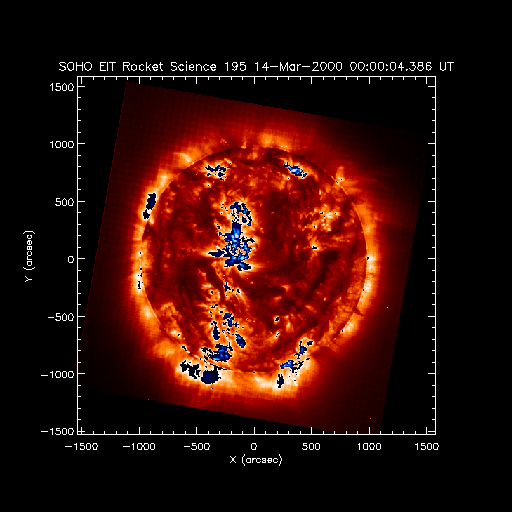

In [8]:
rmap=rot_map(eit_map,roll=100., center=[20,30], /full_size)
plot_map,rmap,/log

### 2.2 Stretching and Resizing a Map

The function __grid_map__ changes the dimensions and pixel spacing of a map. For example, the following command will rebin the 512x512 EIT map displayed in figure 3a, to a 128x128 size map:

In [9]:
gmap=grid_map(eit_map,128,128)
help, gmap

** Structure <628e5348>, 16 tags, length=32928, data length=32917, refs=1:
 DATA INT Array[128, 128]
 XC DOUBLE 15.668818
 YC DOUBLE -11.909447
 DX DOUBLE 21.156204
 DY DOUBLE 21.156204
 TIME STRING '14-Mar-2000 00:00:04.386'
 ID STRING 'SOHO EIT Rocket Science 195'
 DUR FLOAT 4.64100
 XUNITS STRING 'arcsec'
 YUNITS STRING 'arcsec'
 ROLL_ANGLE DOUBLE 0.070000000
 ROLL_CENTER DOUBLE Array[2]
 SOHO BYTE 1
 L0 DOUBLE 0.0000000
 B0 DOUBLE -7.1798987
 RSUN DOUBLE 964.52584

The (x,y) pixel spacings of the output map are computed automatically. To change the spacing between pixels, use the keywords _dx_, _dy_ . For example, to rebin to a pixel spacing of 2 units in x- and 5 in y-directions:


In [10]:
gmap=grid_map(eit_map,dx=2,dy=5)
help, gmap

** Structure <62a9e6d8>, 16 tags, length=1446304, data length=1446293, refs=1:
 DATA INT Array[1344, 538]
 XC DOUBLE 15.668818
 YC DOUBLE -11.909447
 DX DOUBLE 2.0000000
 DY DOUBLE 5.0000000
 TIME STRING '14-Mar-2000 00:00:04.386'
 ID STRING 'SOHO EIT Rocket Science 195'
 DUR FLOAT 4.64100
 XUNITS STRING 'arcsec'
 YUNITS STRING 'arcsec'
 ROLL_ANGLE DOUBLE 0.070000000
 ROLL_CENTER DOUBLE Array[2]
 SOHO BYTE 1
 L0 DOUBLE 0.0000000
 B0 DOUBLE -7.1798987
 RSUN DOUBLE 964.52584

The (x,y) dimensions of the output map are computed automatically. Spacing and output dimension parameters can be combined to produce different stretching and resizing effects. For large images, regridding can be a slow process since each pixel has to be interpolated onto a new spatial scale. 

### 2.3 Extracting a Sub-Region From a Map
The procedure *sub_map* extracts a sub-region from a map. It can be used in two ways, graphically or manually.

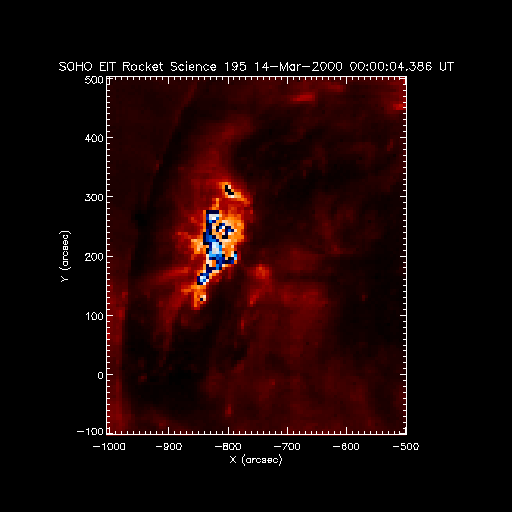

In [11]:
sub_map,eit_map,smap,xrange=[-1000,-500],yrange=[-100,500]
plot_map,smap

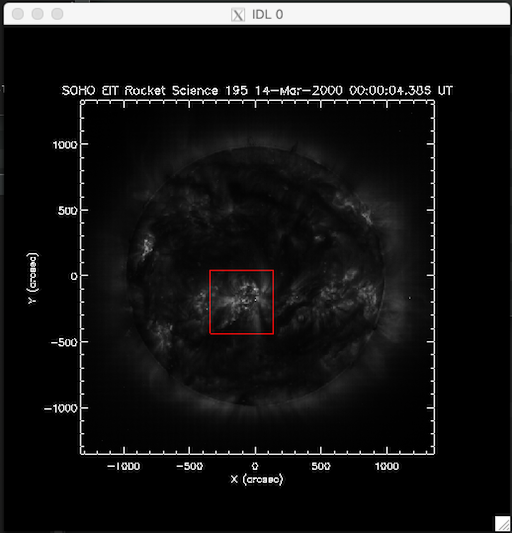Copy the command above into your IDL console for the GUI. A sub-region of map is selected graphically by using the keyword _/plot_, in which case __plot_map__ is called and a "rubber-band" cursor is used to select a sub-region. The sub-region map is returned in smap. The data coordinate limits of the sub-region are returned as two-element vectors in the keywords xrange and yrange. Alternatively, the data coordinate limits can be input via the keywords _xrange=[xmin,xmax]_, _yrange=[ymin,ymax]_, or via the keyword _ref_map_. In the latter case, the extracted sub-region will be extracted according to the _xrange_/_yrange_ values of *ref_map*.

### 2.4 Differencing Maps
The procedure diff_map subtracts two maps to produce a difference map.

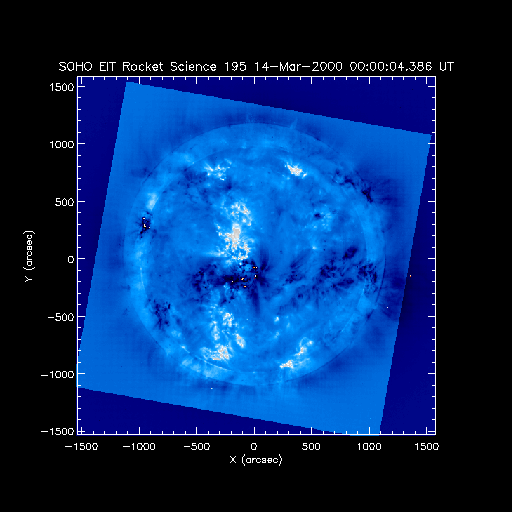

In [12]:
dmap=diff_map(rmap,eit_map,rotate=rotate, ratio=ratio)
plot_map,dmap

The output map _dmap_ contains a difference image of the two images contained in the _map1_ (_rmap_) and _map2_ (*eit_map*) input maps -- the second image is subtracted from the first. The optional keyword /rotate solar rotates the second image to the time of the first image prior to subtraction. Solar rotation is described in section 3.6 .

## 3. Applying Maps to Solar Images
This section describes the steps involved in creating maps for various solar datasets. The routines __index2map__ and __fits2map__ are useful programs for creating maps from any dataset that is in a index/data format. Fits files can be downloaded from VSO and JSOC clients

### 3.1 Creating a _SOHO/EIT_ Map
The following lines read and process EIT images into maps: 

In [39]:
files=eit_files('19-mar-00','20-mar-00',wave=304)
read_eit,files,index,data,outsize=512
index2map,index,data,emap
help, emap[0]

% READFITS: ERROR - Unable to locate file /Users/shelbe/soho/eit/calibrate/cal19951209.fts
% READFITS: ERROR - Unable to locate file /Users/shelbe/soho/eit/calibrate/cal20000401.fts
% READFITS: ERROR - Unable to locate file /Users/shelbe/soho/eit/calibrate/cal20000318.fts
% READFITS: ERROR - Unable to locate file /Users/shelbe/soho/eit/calibrate/cal20000318.fts
%EIT_FIND_LAST_CAL, cal file = /Users/shelbe/soho/eit/calibrate/cal20000318.fts
% READFITS: ERROR - Unable to locate file /Users/shelbe/soho/eit/calibrate/cal20000401.fts
% READFITS: ERROR - Unable to locate file /Users/shelbe/soho/eit/calibrate/cal20000318.fts
% READFITS: ERROR - Unable to locate file /Users/shelbe/soho/eit/calibrate/cal20000318.fts
%EIT_FIND_LAST_CAL, cal file = /Users/shelbe/soho/eit/calibrate/cal20000318.fts

** Structure <91c679f8>, 16 tags, length=524448, data length=524437, refs=2:
 DATA INT Array[512, 512]
 XC DOUBLE 14.354318
 YC DOUBLE -13.171315
 DX DOUBLE 5.2579999
 DY DOUBLE 5.2579999
 TIME STRING '18-Mar-2000 23:59:59.070'
 ID STRING 'SOHO EIT Rocket Science 195'
 DUR FLOAT 12.3390
 XUNITS STRING 'arcsec'
 YUNITS STRING 'arcsec'
 ROLL_ANGLE DOUBLE 0.20999999
 ROLL_CENTER DOUBLE Array[2]
 SOHO BYTE 1
 L0 DOUBLE 0.0000000
 B0 DOUBLE -7.0651971
 RSUN DOUBLE 963.21512

 Each step is summarized as follows:

1. __eit_files__ returns *EIT* filenames for a range of times/dates and wavelength filter. This example returns filenames (string array) for 304 Angstom images.
2. __read_eit__ reads the filenames array and returns an index structure representation of the FITS file header and a 2D data array of image values. The latter is a 3D array when more than one image is read. The optional keyword outsize specifies the dimensions of the output image. For example, setting outsize=512 produces a 512x512 image.
3. __index2map__ converts the corrected outindex and outdata variables into a map. The latter is an array when multiple images are copied. 

In the case of full-disk images, the 1024x1024 array size can lead to IDL out-of-memory problems on some systems. To avoid this problem, there is an optional outsize keyword to rebin images to a smaller dimension (with accompanying loss of spatial resolution).

### 3.2 Converting a FITS File to a Map

FITS files can be converted to maps by using the procedure __fits2map__ . The following example reads and converts a IRIS 1330A Slit-Jaw Image FITS file into a map, and plots the result:

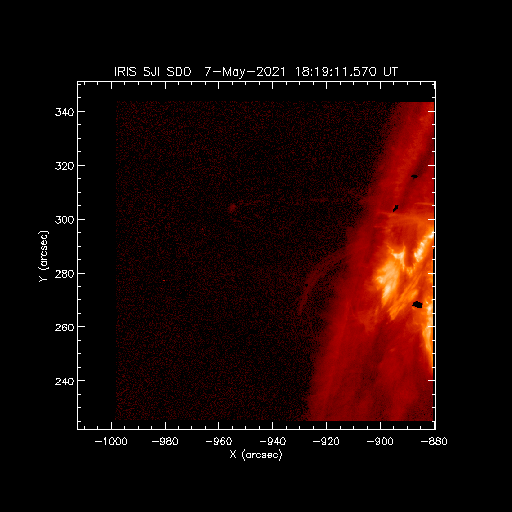

In [14]:
iris_fname='/irisa/data/level2/2021/05/07/20210507_181911_3660259533/iris_l2_20210507_181911_3660259533_SJI_1330_t000.fits'
fits2map,iris_fname,iris_map,header=header
loadct,3
iris_map=iris_map[215]
plot_map,iris_map, /log

### 3.6 Correcting for Solar Differential Rotation

The function __drot_map__ rotates a map using the solar differential rotation formula of Howard, Harvey, and Forgach, Solar Physics, 130, 295, 1990. Since the formula is derived from statistical studies of small-scale magnetic features, it is most accurately applied to photospheric images and is less accurate when applied to transition region and coronal images. The following example demonstrates the differential rotation of the above full-disk *EIT* image over 4 days.

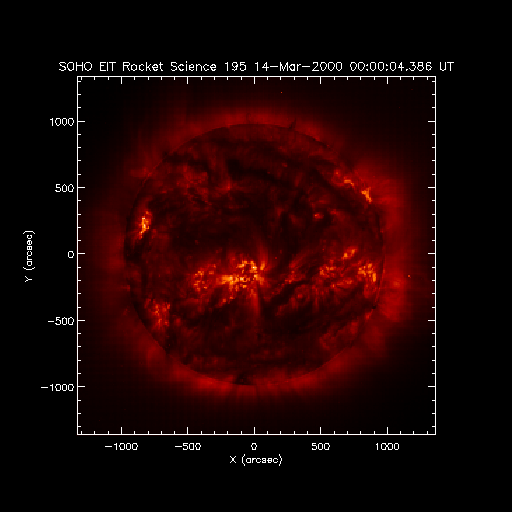

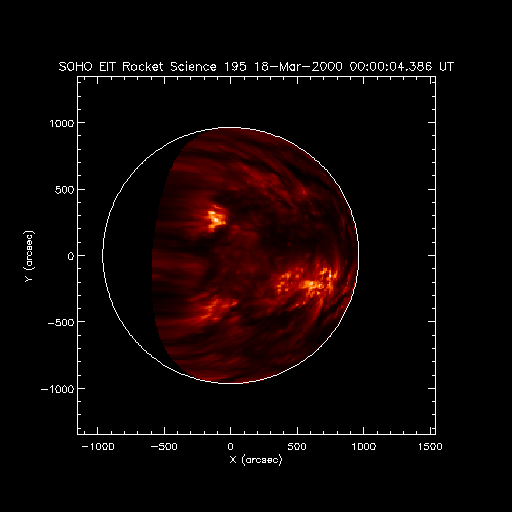

In [33]:
gmap=grid_map(eit_map,256,256)
dmap=drot_map(gmap,4,/days)
plot_map,gmap,/log
plot_map,dmap,/log,/new,/limb

Because solar rotation involves interpolating each pixel to a new location, processing large 512x512 or 1024x1024 images can be very time-consuming and memory-intensive on some systems. In the above example, the *EIT* map is rebinned to a more manageable 256x256 size prior to rotation. The function __drot_map__ accepts map and duration (in hours) as input arguments. It also supports the following keywords:

- _/days_: specifies that input duration is in units of days.
- _/secs_: specifies that input duration is in units of seconds.
- *time=new_time*: specifies the new time to which the image is to be rotated. In this case, the duration argument should not be used (since it always takes precedence).
- *missing=value*: specifies the value assigned to pixels that have rotated out of the field or over the limb -- the default is 0. 

The function __drot_map__ combines regridding, roll-correction, and translation through the following additional keywords:

- *space=[dx,dy]*: specifies new pixel spacings.
- *roll=new_roll*: specifies new roll angle (in degrees).
- *center = [rx,ry]*: specifies new roll center.
- *trans = [xs,ys]*: specifies translation shifts in the x- and y- directions.
- *ncenter = [nx,ny]*: specifies a new center coordinate for the solar-rotated image.
- *ref_map=ref_map*: specifies a reference map to which the input map is to be mapped (i.e, use reference map time, spacing, roll, center, ncenter, etc). 


### 3.7 SDO Maps and VSO Search
SSW provides a set of commands for interacting with the Virtual Solar Observatory directly. Two of these are of particular interest for downloading SDO data and any other data in the VSO.
- *vso_search*: searches for data matching supplied specifications
- *vso_get*: attempts to download data corresponding to the meta-data from a previous VSO search.

Filters for the VSO search include:

Parameters
- Date/time: a start time and end time parameters can be given with "YYYY-mmm-ddTHH:MM:SS" format

Keywords
- Instrument: Specific desired instrument (instr='aia')
- Wavelength: the desired wavelength be as a string (wave=’304’)
- Sample: the candance to search for a subset of observations (sample=600 will try to find a subset observations in the time range which are 600 seconds (10 minutes) apart.
- Physical Observation: Sometimes, the wave keyword is not enough to specify the required data product (e.g., magnetograms, dopplergrams,etc). In this situation the physobs keyword can be used.(instr=’hmi’, physobs=’LOS_magnetic_field’)

In [16]:
result=vso_search('2021-may-07T18:19:00','2021-may-07T18:19:30', instr='aia', wave='193 Angstrom')

Records Returned : JSOC : 3/3
Records Returned : SDAC_AIA : 0/0

Here we have found 3 *AIA* 193A images that match the criteia. To download the image, a out directory is named and because *AIA* are quite large, the __/rice__  keyword is used to download a RICE compressed fits file. Once the file is avaiable, there are many *AIA* specific tools in the SSW instrument package to process the map. Like __read_eit__ above, __read_sdo__ creates a index/data pair specifically for the *AIA* and *HMI* instruments. The __aia_lct__ will set the standard color table for each wavelength channel. Finally, __aia_prep__ provides rotation, scaling, and translation corrections to level 1 images. (The full descriptions of these procedures can be found at https://hesperia.gsfc.nasa.gov/ssw/sdo/aia/idl/)


-------------------------------------------------------------------------------------------
| reading /sanhome/shelbe/SSWIDL/data/aia.lev1.193A_2021-05-07T18_19_16.85Z.image_lev1.fits |
 -------------------------------------------------------------------------------------------

INDEX STRUCT = -> Array[1]
DATA INT = Array[4096, 4096]

INDEX2MPO.PRO: Using JSOC SDO master pointing series aia.master_pointing3h
 Using previously read MPT records.
 AIA_REG: MPO updateed using JSOC SDO master pointing series aia.master_pointing3h

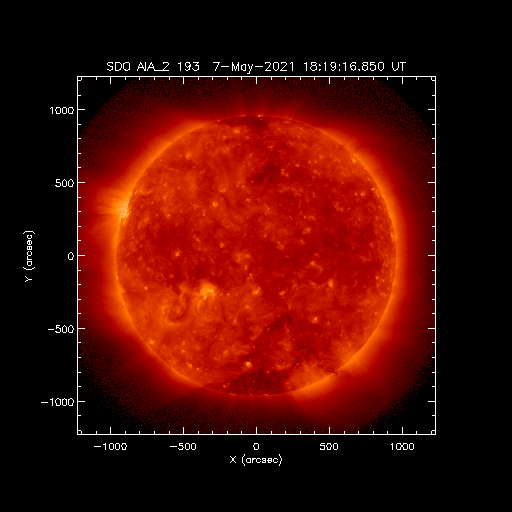

In [38]:
log=vso_get(result[0],out_dir='/sanhome/shelbe/SSWIDL/data',filenames=fnames,/rice)
read_sdo,fnames,index,data,/use_shared_lib
help,index,data
aia_lct, wave='193'
aia_prep,index,data,oindex,odata
index2map,oindex,odata,aia_map
plot_map, aia_map, /log

## 4. OVERLAYING MAPS
Maps are graphically overlayed using the keyword /over in plot_map . In the following example, an *IRIS* map is contoured over an *AIA* map.

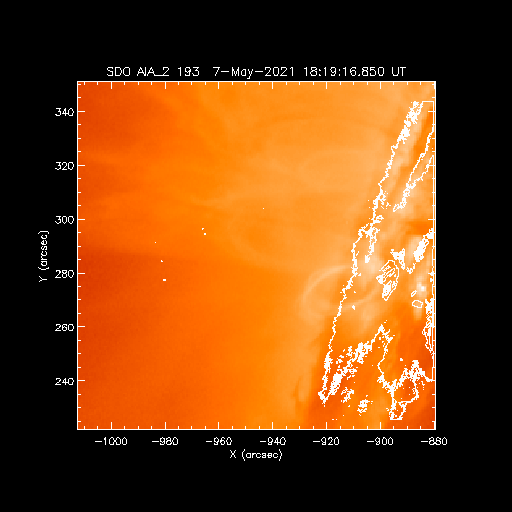

In [36]:
levels=10+findgen(10)*400
plot_map,aia_map,fov=iris_map,/log
plot_map,iris_map,/over,/rotate,/positive,levels=levels

The fov keyword is a map structure from which __plot_map__ infers *xrange* and *yrange* values. In the above example, only the sub-region of *iris_map* that overlaps with that of *iris_map* field-of-view is displayed. This keyword is optional. Different sub-regions can be displayed also via the xrange and yrange keywords.

The _/rotate_ keyword corrects for solar rotation of the overlayed image relative to the first. This correction is important if the time difference between images is more than several hours. The overlayed image can be rotated to a specified time via the keyword time.


The following example shows an overlay of *IRIS* image contours on an *AIA* observation of flare loops. The example illustrates the use of additional keyword options in __plot_map__.


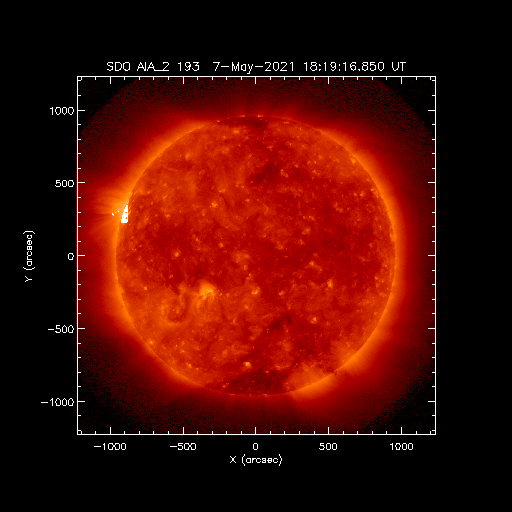

In [19]:
aia_lct, wave='193'
plot_map,aia_map,/log
plot_map,iris_map,/over,/rotate,/positive,levels=levels

Each step is explained below:

- __findgen__ is used to define an array of contour levels
- the *AIA* map specified in *aia_map* is plotted.
- positive *IRIS*  values in the map *iris_map* are overplotted as white contours. 


## References 
- D.M. Zarro (ADNET/GSFC). IDL Map Software for Analyzing Solar Images https://hesperia.gsfc.nasa.gov/rhessidatacenter/complementary_data/maps/
- Daniel Brown, et al. Working with data from the Solar Dynamics Observatory https://www.uclan.ac.uk/sdo/assets/sdo_primer_V1.2.pdf
- Guide to SDO Data Analysis, September 14, 2020. https://www.lmsal.com/sdodocs/doc/dcur/SDOD0060.zip/zip/entry/
- Mark Cheung, Marc DeRosa, 2010. AIA Data Analysis: How to Get AIA Data Using SolarSoft. https://sun.bao.ac.cn/hsos_data/Meeting_report/2010_SDO_Yunnan/summer_school_report/Cheung/Cheung-SSW-JSOC.pdf